In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
import io
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# temp_dir = "C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_"

input_files = [f"file{i+1}.csv" for i in range(3)]
temp_dir =  "C:/Users/hoang/FileCSV_DACN_2025/2Type_"

input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)
df = [dk.read_csv(file) for file in input_files]

# input_zip = "/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type.zip"
# csv_files = []
# with zipfile.ZipFile(input_zip, 'r') as z:
#     csv_files = [f for f in z.namelist() if f.endswith('.csv')]
# print(csv_files)
# df = [dk.read_csv(f'zip://{file}::{input_zip}') for file in csv_files]
# print(df[0].shape)

['C:/Users/hoang/FileCSV_DACN_2025/2Type_file1.csv', 'C:/Users/hoang/FileCSV_DACN_2025/2Type_file2.csv', 'C:/Users/hoang/FileCSV_DACN_2025/2Type_file3.csv']


In [2]:
batch_size = 512
ratio_test_all = 0.15

from dask_ml.model_selection import train_test_split 
# Split 
train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42, shuffle=True)

# def dask_to_tf_dataset(dask_df, batch_size, num_classes): 
#     def generator():
#         for batch in dask_df.to_delayed():
#             batch=batch.compute()  
#             if batch.empty:
#                 continue

#             X = batch.drop(columns='label').values.astype(np.float32)
#             y = batch['label'].values
#             y_onehot = to_categorical(y, num_classes=num_classes)  

#             num_splits = max(1, len(X) // batch_size)  # Đảm bảo không chia nhỏ quá mức
#             X_batches = np.array_split(X, num_splits)
#             y_batches = np.array_split(y_onehot, num_splits)

#             for X_batch, y_batch in zip(X_batches, y_batches):
#                 yield X_batch, y_batch
                
#     output_signature = ( 
#         tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
#         tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
#     )
    
#     return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)


############## binary ########################
# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
############ binary ###########

In [3]:
# train_df1, test_df1 = df1.random_split([1 - ratio_test_all, ratio_test_all])
# train_df2, test_df2 = df2.random_split([1 - ratio_test_all, ratio_test_all])
# train_df3, test_df3 = df3.random_split([1 - ratio_test_all, ratio_test_all])
train_dfs = []
test_dfs = []
for dff in df:
    train_df, test_df =dff.random_split([1 - ratio_test_all, ratio_test_all])
    train_dfs.append(train_df)
    test_dfs.append(test_df)
   

train_gens = [dask_to_tf_dataset(train_df, 512).repeat() for train_df in train_dfs]

test_gens = [dask_to_tf_dataset(test_df , 512) for test_df in test_dfs]

In [4]:
import datetime
import numpy as np
import tenseal as ts
#
from server import Server
from client import Client
num_servers = 1
num_clients = 3

stepsPerEpoch_Clients = [int( np.ceil(train_dfs[index].shape[0] / batch_size)) for index in range(num_clients)]

active_servers_list  = ['server_'+str(i)\
                        for i in range(num_servers)]
active_clients_list  = ['client_'+str(i)\
                        for i in range(num_clients)]

print(active_servers_list)
print(active_clients_list)

def init_he_context():
    """Thiết lập context mã hóa đồng hình"""
    context = ts.context(
        ts.SCHEME_TYPE.CKKS, # ckks cho số thực, bfv cho int
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.generate_galois_keys()
    context.global_scale = 2**40
    return context

context = init_he_context()
agents_dict= {}
serverObjects={}
clientObjects={}
serverObjects = {server_name: Server(server_name=server_name, \
                        active_clients_list=active_clients_list) \
                        for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], test_gens[clientID], \
                        active_clients_list = active_clients_list, he_context=context) \
                        for clientID, client_name in enumerate(active_clients_list)}

for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].set_steps_per_epoch(stepsPerEpoch_Clients[index])
    clientObjects[client_name].get_steps_per_epoch()
    
# lưu dict
agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

# init agents_dict vừa tạo vào client, server
for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

client_name = 'client_1'
print("Agent_Dict: ", agents_dict['client'][client_name])

server = agents_dict['server']['server_0']
print(server)

['server_0']
['client_0', 'client_1', 'client_2']
11944
23891
35836
Agent_Dict:  <client.Client object at 0x00000234512DC510>


In [5]:
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()

====================================== Đang chạy Iteration 1 ======================================
Epoch 1/5
Epoch 1/5
Epoch 1/5


I0000 00:00:1744701849.033297     835 service.cc:152] XLA service 0x7f26ec00de00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744701849.033377     835 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-15 14:24:09.086846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744701849.342098     829 cuda_dnn.cc:529] Loaded cuDNN version 90300


   24/23894 ━━━━━━━━━━━━━━━━━━━━ 1:54 5ms/step - accuracy: 0.5575 - loss: 0.7297

2025-04-15 14:24:12.374750: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

I0000 00:00:1744701852.386899     835 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-15 14:24:12.389497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads

2025-04-15 14:24:12.461081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads



  173/23894 ━━━━━━━━━━━━━━━━━━━━ 3:56 10ms/step - accuracy: 0.7842 - loss: 0.4825

2025-04-15 14:24:13.968447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 14:24:14.056458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  318/11950 ━━━━━━━━━━━━━━━━━━━━ 1:27 8ms/step - accuracy: 0.8589 - loss: 0.3428

2025-04-15 14:24:14.698827: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  402/35842 ━━━━━━━━━━━━━━━━━━━━ 7:14 12ms/step - accuracy: 0.8821 - loss: 0.3053

2025-04-15 14:24:17.165857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  799/11950 ━━━━━━━━━━━━━━━━━━━━ 1:34 8ms/step - accuracy: 0.9229 - loss: 0.2074

2025-04-15 14:24:18.209536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



 1273/23894 ━━━━━━━━━━━━━━━━━━━━ 3:07 8ms/step - accuracy: 0.9398 - loss: 0.1730

2025-04-15 14:24:22.793868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



11950/11950 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9847 - loss: 0.0578
Epoch 2/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 159s 6ms/step - accuracy: 0.9873 - loss: 0.0529
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.9942 - loss: 0.0292
Epoch 3/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 234s 6ms/step - accuracy: 0.9900 - loss: 0.0428
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9935 - loss: 0.0319
Epoch 4/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 151s 6ms/step - accuracy: 0.9925 - loss: 0.0362
11764/11950 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9938 - loss: 0.0290Epoch 3/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.9938 - loss: 0.0289
Epoch 5/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9933 - loss: 0.0315
24004/35842 ━━━━━━━━━━━━━━━━━━━━ 1:18 7ms/step - accuracy: 0.9938 - loss: 0.0286client_0Come end!
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 135s 6ms/step - accuracy: 0.9933 - loss: 0.0312
Epoch 4/5
35842/35842 ━━━━━━━━

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


129/400 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9950 - loss: 0.0000e+00

2025-04-15 14:41:09.172058: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9971 - loss: 0.0000e+00
254/400 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9951 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9952 - loss: 0.0000e+00
495/600 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9954 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9975 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_0 on iteration 1 
------------------------------------------- 
local accuracy: 0.9969499111175537 
global accuracy: 0.9973663091659546 
local compute time: 0:06:34.887060 
Simulated time to receive global weights: 0:16:57.845705 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9954 - loss: 0.0000e+00
 57/400 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9931 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9939 - loss: 0.0000e+00
317/600 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9959 - loss: 0.0000e+00Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.995242178440094 
global accuracy: 0.9940056204795837 
local compute time: 0:11:14.483054 
Simulated time to receive global weights: 0:16:57.845705 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9958 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_2 on iteration 1 
------------------------------------------- 
local accuracy: 0.9952621459960938 
global accuracy: 0.995694637298584 
local compute time: 0:16:57.011214 
Simulated time to receive global weights: 0:16:57.845705 
 

[client_0] :Simulated time for client set() to finish iteration 1: 0:33:56.161431

[client_1] :Simulated time for client set() to finish iteration 1: 0:33:56.161431

[client_2] :Simulated time for client set() 

2025-04-15 14:41:34.129505: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 14:41:34.129553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 14:41:34.136564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  119/35842 ━━━━━━━━━━━━━━━━━━━━ 11:20 19ms/step - accuracy: 0.8586 - loss: 0.3694

2025-04-15 14:41:36.295230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  209/35842 ━━━━━━━━━━━━━━━━━━━━ 7:17 12ms/step - accuracy: 0.8991 - loss: 0.2898

2025-04-15 14:41:36.595247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads



  258/23894 ━━━━━━━━━━━━━━━━━━━━ 4:32 12ms/step - accuracy: 0.9113 - loss: 0.2617

2025-04-15 14:41:36.994000: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  612/23894 ━━━━━━━━━━━━━━━━━━━━ 3:47 10ms/step - accuracy: 0.9494 - loss: 0.1667

2025-04-15 14:41:39.999382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  994/11950 ━━━━━━━━━━━━━━━━━━━━ 1:26 8ms/step - accuracy: 0.9580 - loss: 0.1385

2025-04-15 14:41:41.831141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



 1155/11950 ━━━━━━━━━━━━━━━━━━━━ 1:35 9ms/step - accuracy: 0.9616 - loss: 0.1286

2025-04-15 14:41:44.255341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



11950/11950 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.9879 - loss: 0.0508
Epoch 2/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 166s 7ms/step - accuracy: 0.9907 - loss: 0.0430
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9934 - loss: 0.0330
Epoch 3/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 247s 7ms/step - accuracy: 0.9915 - loss: 0.0388
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9924 - loss: 0.0362
Epoch 4/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 161s 7ms/step - accuracy: 0.9935 - loss: 0.0309
Epoch 3/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9936 - loss: 0.0301
Epoch 5/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.9941 - loss: 0.0272
23819/35842 ━━━━━━━━━━━━━━━━━━━━ 1:22 7ms/step - accuracy: 0.9945 - loss: 0.0257client_0Come end!
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step - accuracy: 0.9940 - loss: 0.0275
Epoch 4/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 219s 6ms/step - accuracy: 0.9946 - loss: 0.0255
Epoch 3/5
23894/2

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9961 - loss: 0.0000e+00
207/600 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9988 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9939 - loss: 0.0000e+00
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9891 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9891 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_0 on iteration 2 
------------------------------------------- 
local accuracy: 0.9959816336631775 
global accuracy: 0.9888744950294495 
local compute time: 0:06:53.036484 
Simulated time to receive global weights: 0:18:09.737141 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9987 - loss: 0.0000e+00
 47/400 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9899 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9909 - loss: 0.0000e+00
318/600 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9973 - loss: 0.0000e+00Arguments:  Performance Metrics for client_1 on iteration 2 
------------------------------------------- 
local accuracy: 0.9939863085746765 
global accuracy: 0.9909287691116333 
local compute time: 0:11:25.452416 
Simulated time to receive global weights: 0:18:09.737141 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9972 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_2 on iteration 2 
------------------------------------------- 
local accuracy: 0.9986702799797058 
global accuracy: 0.9972405433654785 
local compute time: 0:18:08.210166 
Simulated time to receive global weights: 0:18:09.737141 
 

[client_0] :Simulated time for client set() to finish iteration 2: 0:36:19.944304

[client_1] :Simulated time for client set() to finish iteration 2: 0:36:19.944304

[client_2] :Simulated time for client set(

2025-04-15 15:00:12.565497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:00:12.569675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:00:12.581655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  106/35842 ━━━━━━━━━━━━━━━━━━━━ 18:27 31ms/step - accuracy: 0.8658 - loss: 0.3319

2025-04-15 15:00:15.753977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  153/23894 ━━━━━━━━━━━━━━━━━━━━ 9:45 25ms/step - accuracy: 0.9161 - loss: 0.2533 

2025-04-15 15:00:16.252335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:00:16.389798: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  713/11950 ━━━━━━━━━━━━━━━━━━━━ 1:42 9ms/step - accuracy: 0.9615 - loss: 0.1288

2025-04-15 15:00:19.001197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  953/11950 ━━━━━━━━━━━━━━━━━━━━ 1:35 9ms/step - accuracy: 0.9674 - loss: 0.1122

2025-04-15 15:00:20.753779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



 1155/11950 ━━━━━━━━━━━━━━━━━━━━ 1:41 9ms/step - accuracy: 0.9707 - loss: 0.1028

2025-04-15 15:00:23.303510: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



11950/11950 ━━━━━━━━━━━━━━━━━━━━ 91s 7ms/step - accuracy: 0.9895 - loss: 0.0471
12013/23894 ━━━━━━━━━━━━━━━━━━━━ 1:25 7ms/step - accuracy: 0.9911 - loss: 0.0422Epoch 2/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 181s 7ms/step - accuracy: 0.9923 - loss: 0.0376
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.9937 - loss: 0.0316
Epoch 3/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 270s 7ms/step - accuracy: 0.9919 - loss: 0.0376
11894/11950 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9948 - loss: 0.0258Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.9948 - loss: 0.0258
Epoch 4/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 174s 7ms/step - accuracy: 0.9937 - loss: 0.0303
Epoch 3/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9941 - loss: 0.0282
Epoch 5/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9943 - loss: 0.0273
23866/35842 ━━━━━━━━━━━━━━━━━━━━ 1:25 7ms/step - accuracy: 0.9934 - loss: 0.0309client_0Come end!
23894/23894 ━━━━━━━━━━━━━━━━━━━

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9935 - loss: 0.0000e+00
210/600 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9994 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9945 - loss: 0.0000e+00
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9887 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9886 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_0 on iteration 3 
------------------------------------------- 
local accuracy: 0.9933866262435913 
global accuracy: 0.9883806705474854 
local compute time: 0:07:23.053061 
Simulated time to receive global weights: 0:18:55.311059 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9994 - loss: 0.0000e+00
 62/400 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9916 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9924 - loss: 0.0000e+00
281/600 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9993 - loss: 0.0000e+00Arguments:  Performance Metrics for client_1 on iteration 3 
------------------------------------------- 
local accuracy: 0.9945901036262512 
global accuracy: 0.9925082325935364 
local compute time: 0:12:13.217766 
Simulated time to receive global weights: 0:18:55.311059 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9992 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_2 on iteration 3 
------------------------------------------- 
local accuracy: 0.9993480443954468 
global accuracy: 0.999102771282196 
local compute time: 0:18:54.266307 
Simulated time to receive global weights: 0:18:55.311059 
 

[client_0] :Simulated time for client set() to finish iteration 3: 0:37:51.092141

[client_1] :Simulated time for client set() to finish iteration 3: 0:37:51.092141

[client_2] :Simulated time for client set(

2025-04-15 15:19:39.320162: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:19:39.320287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:19:39.320380: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



   99/35842 ━━━━━━━━━━━━━━━━━━━━ 13:38 23ms/step - accuracy: 0.8882 - loss: 0.2941

2025-04-15 15:19:41.490683: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  169/35842 ━━━━━━━━━━━━━━━━━━━━ 8:51 15ms/step - accuracy: 0.9175 - loss: 0.2331

2025-04-15 15:19:41.741279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads



  263/35842 ━━━━━━━━━━━━━━━━━━━━ 6:36 11ms/step - accuracy: 0.9362 - loss: 0.1898

2025-04-15 15:19:42.148141: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  473/11950 ━━━━━━━━━━━━━━━━━━━━ 3:11 17ms/step - accuracy: 0.9678 - loss: 0.1218

2025-04-15 15:19:47.139440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  928/11950 ━━━━━━━━━━━━━━━━━━━━ 2:06 11ms/step - accuracy: 0.9768 - loss: 0.0929

2025-04-15 15:19:49.864091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



 1426/35842 ━━━━━━━━━━━━━━━━━━━━ 5:51 10ms/step - accuracy: 0.9746 - loss: 0.0903

2025-04-15 15:19:53.765469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



11950/11950 ━━━━━━━━━━━━━━━━━━━━ 96s 8ms/step - accuracy: 0.9909 - loss: 0.0433
Epoch 2/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 181s 7ms/step - accuracy: 0.9913 - loss: 0.0407
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.9944 - loss: 0.0284
Epoch 3/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 262s 7ms/step - accuracy: 0.9925 - loss: 0.0357
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.9933 - loss: 0.0327
Epoch 4/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 165s 7ms/step - accuracy: 0.9923 - loss: 0.0362
Epoch 3/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.9933 - loss: 0.0323
Epoch 5/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.9937 - loss: 0.0296
24296/35842 ━━━━━━━━━━━━━━━━━━━━ 1:24 7ms/step - accuracy: 0.9943 - loss: 0.0268client_0Come end!
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 236s 7ms/step - accuracy: 0.9943 - loss: 0.0269
Epoch 3/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 152s 6ms/step - accuracy: 0.9927 - loss: 0.0337
Epoch 4/5
23894/2

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9935 - loss: 0.0000e+00


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9951 - loss: 0.0000e+00
181/200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9898 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9898 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_0 on iteration 4 
------------------------------------------- 
local accuracy: 0.9935125112533569 
global accuracy: 0.989658772945404 
local compute time: 0:07:21.766721 
Simulated time to receive global weights: 0:17:41.548405 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9953 - loss: 0.0000e+00
 75/400 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9929 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9936 - loss: 0.0000e+00
256/600 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9931 - loss: 0.0000e+00Arguments:  Performance Metrics for client_1 on iteration 4 
------------------------------------------- 
local accuracy: 0.9950876235961914 
global accuracy: 0.993710994720459 
local compute time: 0:12:18.855894 
Simulated time to receive global weights: 0:17:41.548405 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9928 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_2 on iteration 4 
------------------------------------------- 
local accuracy: 0.9952427744865417 
global accuracy: 0.9925995469093323 
local compute time: 0:17:40.368438 
Simulated time to receive global weights: 0:17:41.548405 
 

[client_0] :Simulated time for client set() to finish iteration 4: 0:35:23.566833

[client_1] :Simulated time for client set() to finish iteration 4: 0:35:23.566833

[client_2] :Simulated time for client set(

2025-04-15 15:37:51.672491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:37:51.676577: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads

2025-04-15 15:37:51.710937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  118/35842 ━━━━━━━━━━━━━━━━━━━━ 12:09 20ms/step - accuracy: 0.9204 - loss: 0.2403

2025-04-15 15:37:54.059262: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  155/23894 ━━━━━━━━━━━━━━━━━━━━ 6:44 17ms/step - accuracy: 0.9470 - loss: 0.1847

2025-04-15 15:37:54.296775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 224 bytes spill stores, 220 bytes spill loads



  311/11950 ━━━━━━━━━━━━━━━━━━━━ 1:55 10ms/step - accuracy: 0.9741 - loss: 0.1196

2025-04-15 15:37:54.747098: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



  397/35842 ━━━━━━━━━━━━━━━━━━━━ 10:52 18ms/step - accuracy: 0.9593 - loss: 0.1405

2025-04-15 15:37:58.941506: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



  883/11950 ━━━━━━━━━━━━━━━━━━━━ 2:02 11ms/step - accuracy: 0.9841 - loss: 0.0770

2025-04-15 15:38:01.440868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 276 bytes spill stores, 264 bytes spill loads



 1148/11950 ━━━━━━━━━━━━━━━━━━━━ 2:00 11ms/step - accuracy: 0.9857 - loss: 0.0699

2025-04-15 15:38:04.495810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 236 bytes spill stores, 212 bytes spill loads



11950/11950 ━━━━━━━━━━━━━━━━━━━━ 100s 8ms/step - accuracy: 0.9922 - loss: 0.0409
Epoch 2/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 190s 8ms/step - accuracy: 0.9921 - loss: 0.0384
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.9938 - loss: 0.0316
Epoch 3/5
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 274s 8ms/step - accuracy: 0.9918 - loss: 0.0390
Epoch 2/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.9929 - loss: 0.0344
Epoch 4/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 181s 8ms/step - accuracy: 0.9934 - loss: 0.0316
Epoch 3/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - accuracy: 0.9944 - loss: 0.0279
Epoch 5/5
11950/11950 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - accuracy: 0.9925 - loss: 0.0356
24321/35842 ━━━━━━━━━━━━━━━━━━━━ 1:29 8ms/step - accuracy: 0.9926 - loss: 0.0344client_0Come end!
35842/35842 ━━━━━━━━━━━━━━━━━━━━ 252s 7ms/step - accuracy: 0.9927 - loss: 0.0340
Epoch 3/5
23894/23894 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9943 - loss: 0.0273
Epoch 4/5
23894/

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9935 - loss: 0.0000e+00
219/600 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9939 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9954 - loss: 0.0000e+00
465/600 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9937 - loss: 0.0000e+00

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9910 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_0 on iteration 5 
------------------------------------------- 
local accuracy: 0.9934350848197937 
global accuracy: 0.9906464219093323 
local compute time: 0:07:45.395626 
Simulated time to receive global weights: 0:18:55.457838 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9936 - loss: 0.0000e+00
 58/400 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9934 - loss: 0.0000e+00 

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9943 - loss: 0.0000e+00
257/600 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9900 - loss: 0.0000e+00Arguments:  Performance Metrics for client_1 on iteration 5 
------------------------------------------- 
local accuracy: 0.9954740405082703 
global accuracy: 0.9944355487823486 
local compute time: 0:13:01.448095 
Simulated time to receive global weights: 0:18:55.457838 
 

600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9896 - loss: 0.0000e+00
Arguments:  Performance Metrics for client_2 on iteration 5 
------------------------------------------- 
local accuracy: 0.9935709834098816 
global accuracy: 0.9893463253974915 
local compute time: 0:18:54.605720 
Simulated time to receive global weights: 0:18:55.457838 
 

[client_0] :Simulated time for client set() to finish iteration 5: 0:37:51.385699

[client_1] :Simulated time for client set() to finish iteration 5: 0:37:51.385699

[client_2] :Simulated time for client se

In [5]:
from tensorflow.keras.models import load_model
# tempdirs = ["D:/DoAnChuyenNganh_Train/client_0_log/11h18p__02-04-2025/", "D:/DoAnChuyenNganh_Train/client_1_log/11h18p__02-04-2025/",  "D:/DoAnChuyenNganh_Train/client_2_log/11h18p__02-04-2025/"]
timeFolder="14h24p__15-04/"
tempdirs = [f"D:/DoAnChuyenNganh_Train/log/client_{i}_log/" for i in range(len(active_clients_list))]


model_names =[timeFolder+f"model_{i+1}.keras" for i in range(5)]
print(model_names)
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models['client_0'])

['14h24p__15-04/model_1.keras', '14h24p__15-04/model_2.keras', '14h24p__15-04/model_3.keras', '14h24p__15-04/model_4.keras', '14h24p__15-04/model_5.keras']
[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

import numpy as np

num_batch_test_eachClient  =  []
for index, test_df in enumerate(test_dfs):
    num_samples_test = test_df.shape[0].compute()
    # Tính số batch
    num_batches_test = int(np.ceil(num_samples_test / batch_size))
    num_batch_test_eachClient.append(num_batches_test)

print("Num Batch Each Client: ", num_batch_test_eachClient)
X_tests = {}
Y_tests = {}
Y_preds= {}
for i, client_name in enumerate(active_clients_list):
    Y_tests[client_name]={}
    Y_preds[client_name]={}

# for i, client_name in enumerate(active_clients_list):
#     X_test = []
#     y_test = []
#     for X_batch, y_batch in test_gens[i].take(num_batch_test_eachClient[i]):
#         X_test.extend(X_batch.numpy().flatten())
#         y_test.extend(y_batch.numpy().flatten())
#         y_pred = []
#         for iteration in range(5):    
#     # .as_numpy_iterator():
#         # # take(12000):
#         # X_test_list.append(X_batch.numpy())
#         # y_test_list.append(y_batch.numpy())  # .numpy()

#         # # Gộp tất cả batch lại
#         # X_test = np.concatenate(X_test_list, axis=0)
#         # y_test = np.concatenate(y_test_list, axis=0)

#         # # Nếu y_test đang ở dạng one-hot, chuyển về dạng số
#         # y_test = np.argmax(y_test, axis=1)
#             y_pred_pre = models[client_name][iteration].predict(X_batch, verbose=0)
#             y_pred.extend((y_pred_pre > 0.5).astype(int).flatten())
    
#         Y_tests[client_name][iteration] = y_test
#         Y_preds[client_name][iteration] = y_pred
    
# print(Y_preds)

Num Batch Each Client:  [2110, 4218, 6327]


1087453
<Sequential name=sequential, built=True>
33983/33983 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step
<Sequential name=sequential, built=True>
33983/33983 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
<Sequential name=sequential, built=True>
33983/33983 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step
<Sequential name=sequential, built=True>
33983/33983 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step
<Sequential name=sequential, built=True>
33983/33983 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
Precision Score:  [0.995231511658705, 0.9986683667843743, 0.999377579273767, 0.9953000006574739, 0.9936100079241903]
Recall Score:  [0.9998471385179796, 0.9999122461862475, 0.9999367795105224, 0.9998999795241101, 0.9997716513663646]
F1 Score:  [0.9975339859476268, 0.9992899194016086, 0.9996571011891089, 0.9975946874129192, 0.9966813066696517]


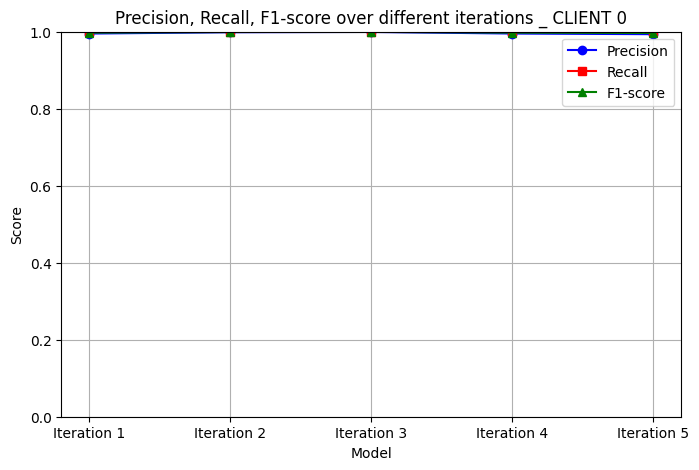

KeyError: 4

In [ ]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[i].take(num_batch_test_eachClient[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models[client_name][iteration])
    y_pred_pre = models[client_name][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))


Precision Score:  [0.995231511658705, 0.9986683667843743, 0.999377579273767, 0.9953000006574739, 0.9936100079241903]
Recall Score:  [0.9998471385179796, 0.9999122461862475, 0.9999367795105224, 0.9998999795241101, 0.9997716513663646]
F1 Score:  [0.9975339859476268, 0.9992899194016086, 0.9996571011891089, 0.9975946874129192, 0.9966813066696517]


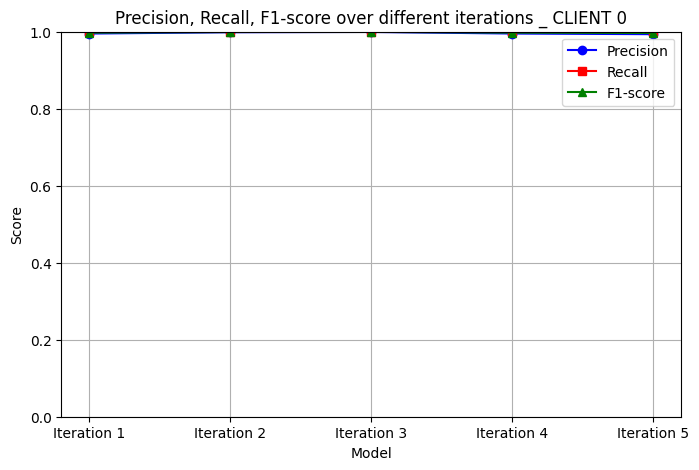

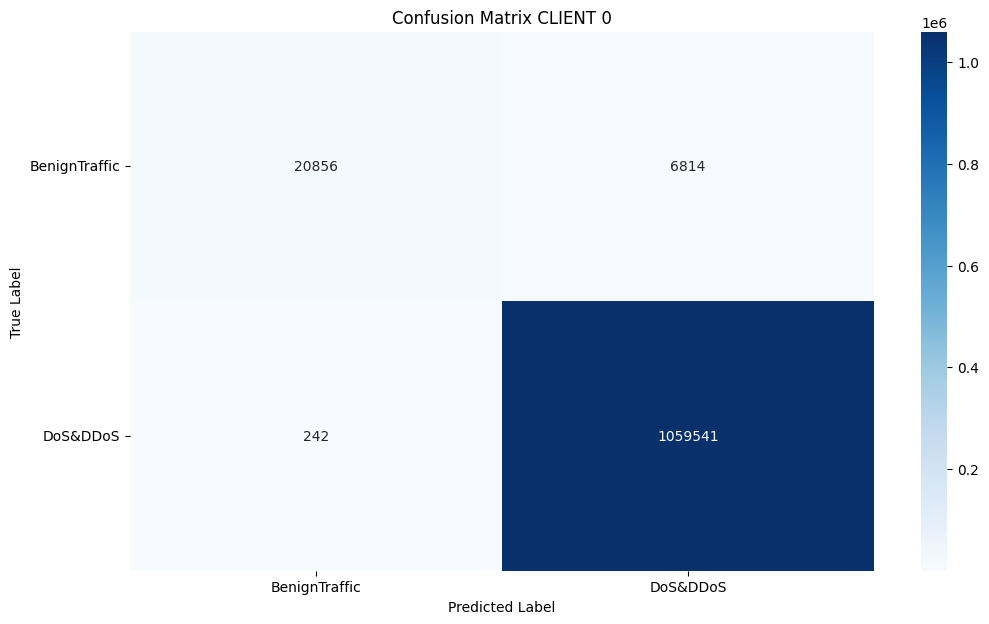

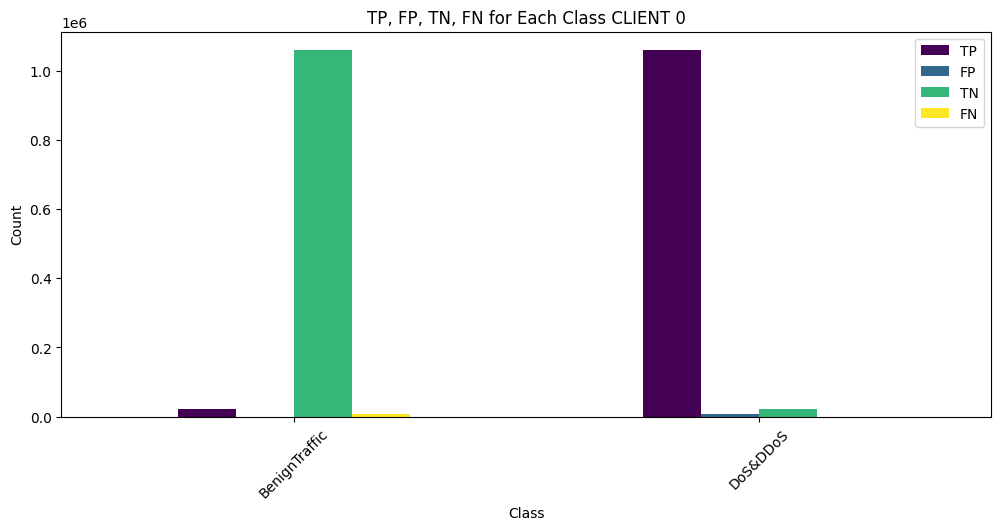

In [22]:
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'DoS&DDoS']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.show()


# attack_types = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']

metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

In [ ]:
# Client 1
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []
y_pred = []

Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []

print(num_batch_test_eachClient[1])

for X_batch, y_batch in test_gens[1].take(num_batch_test_eachClient[1]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

for iteration in range(len(Iterations)):
    y_pred_pre = models['client_1'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'DoS&DDoS']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()

# attack_types = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']

metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

4218
53420/67476 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step

KeyboardInterrupt: 

101225/101225 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step
101225/101225 ━━━━━━━━━━━━━━━━━━━━ 315s 3ms/step
101225/101225 ━━━━━━━━━━━━━━━━━━━━ 297s 3ms/step
101225/101225 ━━━━━━━━━━━━━━━━━━━━ 360s 4ms/step
101225/101225 ━━━━━━━━━━━━━━━━━━━━ 382s 4ms/step
Precision Score:  [0.9952877042000102, 0.9986863582160669, 0.9993854742059051, 0.9953277865053534, 0.9936845498947006]
Recall Score:  [0.9998520654295282, 0.9999132032712863, 0.9999337937361271, 0.9998998986632354, 0.9997842752837445]
F1 Score:  [0.9975646637786918, 0.999299404192811, 0.9996595587818475, 0.9976086040318876, 0.9967250804518568]


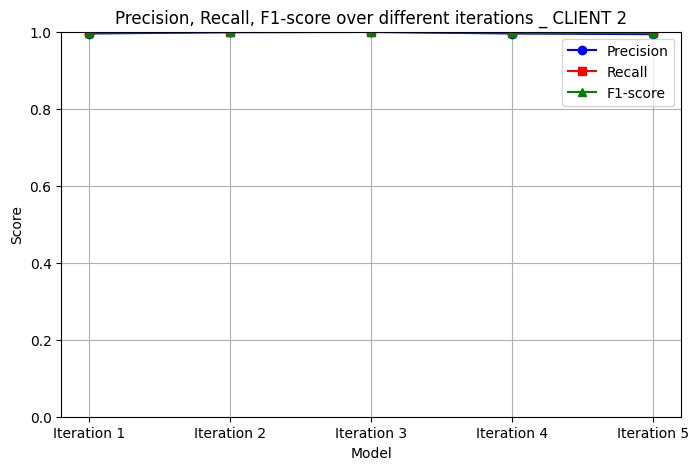

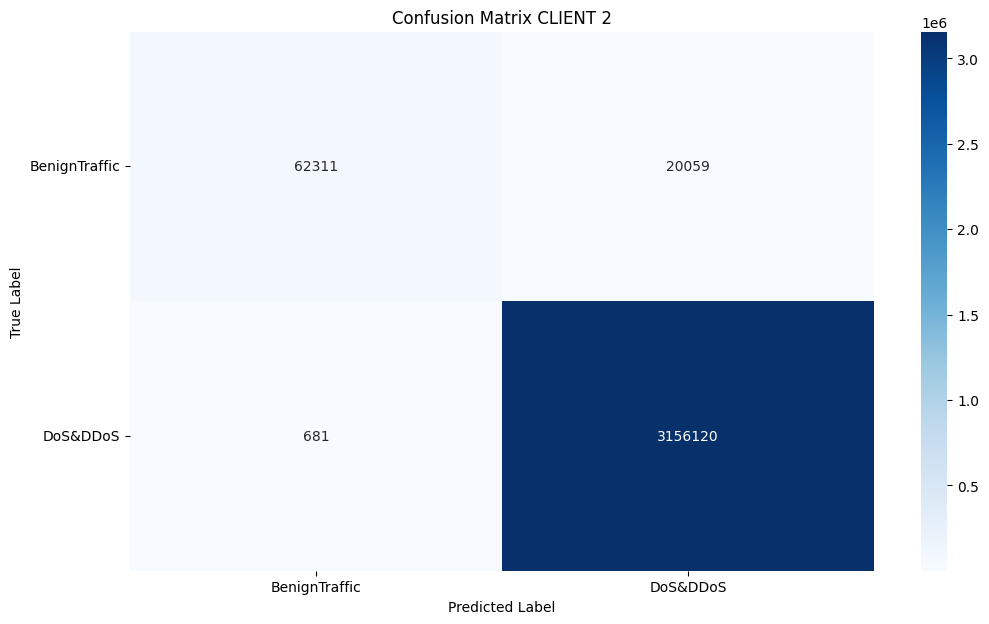

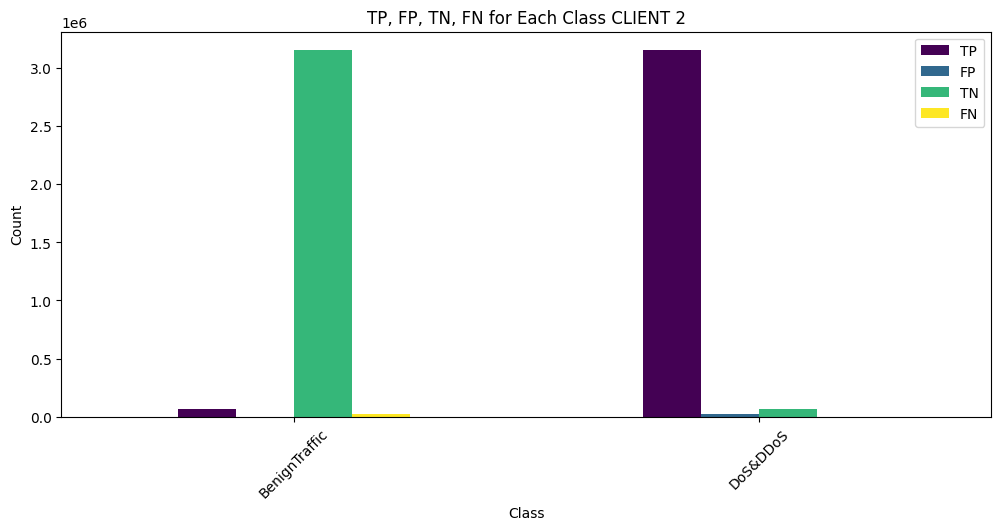

In [27]:
# Client 2
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []

y_pred = []
Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(num_batch_test_eachClient[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

for iteration in range(len(Iterations)):
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'DoS&DDoS']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.show()


# attack_types = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']

metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

In [ ]:
# Client_0 
import matplotlib.pyplot as plt
import numpy as np

file_dir= "log/client_0_log/14h24p__15-04/"
file_names = [f"Iteration_{index+1}.csv" for index in range(5)]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(18, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [ ]:
# Client_1
import matplotlib.pyplot as plt
import numpy as np

file_dir= "log/client_1_log/14h24p__15-04/"
file_names = [f"Iteration_{index+1}.csv" for index in range(5)]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(18, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [ ]:
# Client_2
import matplotlib.pyplot as plt
import numpy as np

file_dir= "log/client_2_log/14h24p__15-04/"
file_names = [f"Iteration_{index+1}.csv" for index in range(5)]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(18, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs _Client 2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()